# 5 Sklearn Mistakes That Silently Tell You Are a Rookie
## No error messages - that's what makes them subtle...
![](images/unsplash.jpg)
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://unsplash.com/@santabarbara77?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText'>Varvara Grabova</a>
        on 
        <a href='https://unsplash.com/s/photos/mistake?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText'>Unsplash</a>
    </strong>
</figcaption>

### Setup

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams

rcParams["figure.figsize"] = [12, 9]
rcParams["figure.autolayout"] = True
rcParams["xtick.labelsize"] = 15
rcParams["ytick.labelsize"] = 15
rcParams["legend.fontsize"] = "small"

warnings.filterwarnings("ignore")

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=200,
    n_features=5,
    n_informative=4,
    n_redundant=1,
    n_classes=3,
    weights=[0.4, 0.4, 0.3],
)

### Introduction

### Using `fit` or `fit_transform` everywhere

Let's start with the most serious mistake - a mistake that is related to *data leakage*. Data leakage is subtle and can be destructive to model performance. It occurs when information that would not be available at prediction time is used during the model training. Data leakage causes models to give very optimistic results, even in cross-validation but perform terribly when testing on actual novel data. 

Data leakage is common during data preprocessing, particularly if the training and test sets are not separated. Many Sklearn preprocessing transformers such as imputers, normalizers, standardization functions and log transformers tap into the underlying distribution of the data during the fit time. 

For example, `StandardScaler` normalizes the data by subtracting the mean from each sample and dividing by the standard deviation. Calling the `fit()` function on the full data (X) allows the transformer to learn the mean and standard deviation of the whole distribution of each feature. After transformation, if this data is then split into train and test sets, the train set would be contaminated because `StandardScaler` leaked important information from the actual distribution. 

Even though this might not be apparent to us, Sklearn algorithms are powerful enough to notice this and take advantage during testing. In other words, the train data would be too perfect for the model because it has useful information of the test set and the test would not be novel enough to test the model's performance on actual unseen data.

The easiest solution is to never call `fit` on the full data. Before doing any preprocessing, always split the data into train and test sets. Even after the split, you should never call `fit` or `fit_transform` on the test set because you will end up at the same problem. 

Since both train and test sets should receive the same preprocessing steps, a golden rule is to use `fit_transform` on the train data - this ensures that the transformer learns only from the train set and transforms it simultaneously. Then, call the `transform` method on the test set to transform it based on the information learned only from the training data.

A more robust solution would be using Sklearn's built-in pipelines. Pipeline classes are specifically built to guard algorithms from data leakage. Using pipelines ensures that only the training data is used during `fit` and the test data is used only for calculations. You can learn about them in detail in my separate article:

https://towardsdatascience.com/how-to-use-sklearn-pipelines-for-ridiculously-neat-code-a61ab66ca90d?source=your_stories_page-------------------------------------

### Judging Model Performance Only By Test Scores

You got a test score over 0.85 - should you be celebrating? Big, fat NO!

Even though high test scores generally mean robust performance, there are important caveats to interpreting test results. First and most importantly, regardless of the value, test scores should only be judged based on the score you get from training.

The only time you should be happy with your model is when the training score is higher than the test score and both are high enough to satisfy the expectations of your unique case. However, this does not imply that the higher the difference between train and test scores, the better. 

For example, 0.85 training score and 0.8 test score suggests a robust model that is neither overfit nor underfit. But, if the training score is over 0.9 and the test score is 0.8, your model is overfit - instead of generalizing during training, the model memorized some of the training data resulting in a much lower test score than training. You will often see such cases with tree-based and ensemble models. Algorithms such as Random Forests tend to achieve very high training scores if their tree depth is not controlled which leads to overfitting. You can read [this discussion](https://stats.stackexchange.com/questions/156694/how-can-training-and-testing-error-comparisons-be-indicative-of-overfitting?noredirect=1&lq=1) on StackExchange to learn more about this difference between train and test scores.

There is also the case where the test score is higher than train. If the test score is higher than the test score even in the slightest, feel alarmed because you made a blunder! The major cause of such scenarios is data leakage and we discussed an example of that in the last section. 

Sometimes, it is also possible to get a good training score and extremely low testing score. When the difference between train and test score is unusually large, the problem will often be associated with the test set rather than overfitting. One reason this might happen is using different preprocessing steps for the train and test sets, or simply forgetting to apply preprocessing to the test set.

In summary, always examine the gap between train and test scores closely. Doing so will tell you whether you should apply regularization to overcome overfitting, look for possible mistakes you made during preprocessing or the best case scenario, prepare the model for final evaluation and deployment.

### Generating Incorrect Train/Test Sets in Classification

A common mistake among beginners is forgetting to generate stratified train and test sets for classification. 

A model is more likely to generate correct predictions when the distribution of the new data matches that of training as much as possible. In classification, we only care about the class weights or proportions. For example, in 3-class classification problem, let's say the class weights of the full data are 0.4, 0.3, 0.3. When we divide this data into train and test sets, the distributions of both sets should reflect the distribution of the full data. 

We commonly use `train_test_split` function of Sklearn to divide the data and Sklearn provides handy argument - `stratify` to generate stratified splits. Here is an example train/test sets with and without stratified splits:

In [5]:
# Look at the class weights before splitting
pd.Series(y).value_counts(normalize=True)

1    0.4
0    0.4
2    0.2
dtype: float64

In [6]:
# Generate unstratified split
X_train, X_test, y_train, y_test = train_test_split(X, y)
# Look at the class weights of train set
pd.Series(y_train).value_counts(normalize=True)

0    0.42
1    0.38
2    0.20
dtype: float64

In [7]:
# Look at the class weights of the test set
pd.Series(y_test).value_counts(normalize=True)

1    0.46
0    0.34
2    0.20
dtype: float64

As you can see, both train and test sets have different class weights for the first and second classes. Let's fix that:

In [8]:
# Generate stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# Train set class weights
pd.Series(y_train).value_counts(normalize=True)

1    0.4
0    0.4
2    0.2
dtype: float64

In [10]:
# Train set class weights
pd.Series(y_test).value_counts(normalize=True)

1    0.4
0    0.4
2    0.2
dtype: float64

Setting `stratify` to the target (`y`) yielded identical distributions in both the train and test sets. 

Altered class weights are a serious problem that might make a model make more biased towards a particular class. Forgetting to generate stratified splits might result in more favorable train or test sets or cause problems such as these:

![](https://miro.medium.com/proxy/1*QrFi76DR3mka7c_akr7WFw.png)

The above is the performance of a KNN classifier I have built when I have just started learning Sklearn. As you can see, almost all test scores are higher than training because I had forgotten to generate stratified splits. As a result, the test set yielded too favorable distribution for my model to take advantage. After fixing the problem:

![](https://miro.medium.com/proxy/1*MOBa9yEvtppQwdgMT7ZvZg.png)

It is all back to normal. 

When using cross-validation or pipelines, you don't have to worry about this problem, because CV splitters perform stratification under the hood using `StratifiedKFold` for classification problems.

### Using `LabelEcoder` to Encode the X array

Ever got annoyed when you found out that `LabelEncoder` encodes categorical columns only one at a time? Compared to other text transformers such as `OneHotEncoder` which can transform multiple features at the same time, this seems kind of a let down by Sklearn. 

But I am here to tell you that it isn't! It is simply the result of your inexperience and your unwillingness to read the awesome documentation of Sklearn. Here is an excerpt of `LabelEncoder`'s 2-sentence documentation:

> This transformer should be used to encode target values, i.e. `y`, and not the input `X`.

Then, what do you use to encode ordinal text features? If you kindly move on to the Sklearn user guide on encoding categorical features, you will see that it clearly states:

> To convert categorical features to integer codes, we can use the `OrdinalEncoder`. This estimator transforms each categorical feature to one new feature of integers (0 to n_categories - 1)

Using `OrdinalEncoder` allows us to transform multiple columns at once as expected and it has the benefit of being able to integrate into Pipeline instances, which `LabelEncoder` cannot. The encoder follows the familiar transformer API of Sklearn:

```python
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder(handle_unknown='ignore')

X_train = oe.fit_transform(X_train)
X_test = oe.transform(X_test)
```

You can learn a lot about Sklearn by just reading the documentation and the user guide!

### Judging Model Performance Without Cross-validation

I think you are already comfortable with the topic of overfitting. It is such a pressing issue in machine learning that countless techniques have been devised to overcome it. 

The most basic one is holding out a part of the data as a test set to simulate and measure a model's performances on unseen data. However, hyperparameters of the models can be tweaked until the model reaches the maximum score on that particular test set, which again means overfitting. To go around this once again, we might take another part of the full data as a 'validation' set. A model would be trained on the training data, fine tune its performance on the validation set and run it through the test set for final evaluation. 

But dividing our precious data into 3 sets would mean smaller amount of data a model can learn from. The whole performance of the model would depend on that particular pair of train and validation set.

So, ML practitioners commonly use a procedure called K-fold cross-validation (CV for short). Depending on its value, the full data is divided into *K* sets called folds and for each fold, the model would use the K - 1 number of folds as training data and the rest as a testing set. After the CV is done, the model will have been trained and tested on all data. Here is the diagram of this process by Sklearn for 5-fold CV:

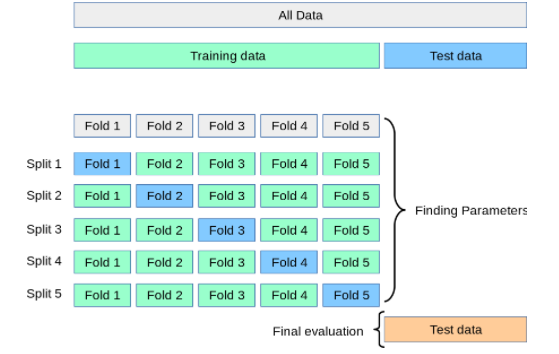

Another benefit of cross-validation is that it completely takes out the randomness out of the question. In other words, you won't have to worry that `train_test_split` accidentally generates too favorable train and test sets that bias the objective function of your model.

### Using Accuracy as a Metric to Evaluate the Performance of Classifiers

By default, all Sklearn classifiers use *accuracy* as a scoring method when we call `.score` function. Because of this easy access to the metric, it is common to see beginners using it extensively to judge the performance of their model. Unfortunately, vanilla *accuracy* score is useful in only one scenario - a binary classification problem with equal, balanced class weights.

Other times, it is such a misleading metric that even the worst performing models can hide behind high accuracy scores. For example, if the model is detecting spam emails, it can reach over 90% accuracy without even finding a single spam email. Why? As spam emails are not as common, the classifier can detect all non-spam emails, and this can give a huge boost to its accuracy even thought the classifier completely fails at its purpose.

This problem is even worse for multiclass classification. If you achieve 80% accuracy, does it mean the model is more accurate at detecting class 1, class 2, class 3 or even all of them? Accuracy can never answer such questions but thankfully, there are multiple other classification metrics that give much more informative summary of any classifier's performance. You can read about them in my separate post where I discuss metrics that are applicable to both binary and multiclass problems:

https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd?source=your_stories_page-------------------------------------

### Not Controlling the Randomness While Doing Experiments